In [1]:
import torch

import pyro
from pyro.distributions import Beta, Gamma, Dirichlet, Categorical, constraints
from pyro.infer import Predictive, autoguide, SVI, Trace_ELBO, config_enumerate
from pyro.optim import Adam, ClippedAdam

import pandas as pd
import seaborn as sns

/var/folders/5_/k3hfqsqs4_x7b_jy_10v97j00000gn/T/ipykernel_4442/301402387.py:8: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


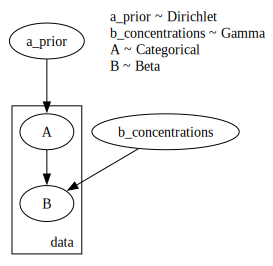

In [2]:
@config_enumerate
def model(a_obs=None, N=None):
    a_prior = pyro.sample("a_prior", Dirichlet(torch.ones(2))) # uniform prior over A
    b_concentrations = pyro.sample("b_concentrations", Gamma(torch.ones(2,2), rate=torch.tensor([0.5, 0.5])).to_event())
    with pyro.plate('data', N):
        A = pyro.sample('A', Categorical(a_prior), obs=a_obs)
        B = pyro.sample('B', Beta(b_concentrations[A, 0], b_concentrations[A, 1]))
        return A, B

pyro.render_model(lambda: model(N=100), render_distributions=True, render_params=True)

In [3]:
# Sample the prior
prior_samples = Predictive(model, posterior_samples={}, num_samples=1000)()

In [4]:
# generate samples from parameterized model
pyro.clear_param_store()
a_prior = torch.tensor([0.5, 0.5])
b_concentrations = torch.tensor([[8., 4.],
                                 [4., 8.]])
conditioned_model = pyro.poutine.condition(model, 
                                           data={
                                               'a_prior': a_prior,
                                               'b_concentrations': b_concentrations}) 

parameterized_samples = Predictive(conditioned_model, posterior_samples={}, num_samples=5000)()

In [5]:
df = pd.DataFrame({'A': parameterized_samples['A'].squeeze(), 'B': parameterized_samples['B'].squeeze()})

In [6]:
print(len(parameterized_samples['A']))
print(len(parameterized_samples['B']))

5000
5000


In [7]:
a_samples = parameterized_samples['A'].squeeze()
print(f"{sum(a_samples==0)=}")
print(f"{sum(a_samples==1)=}")

sum(a_samples==0)=tensor(2488)
sum(a_samples==1)=tensor(2512)


<Axes: xlabel='B', ylabel='Count'>

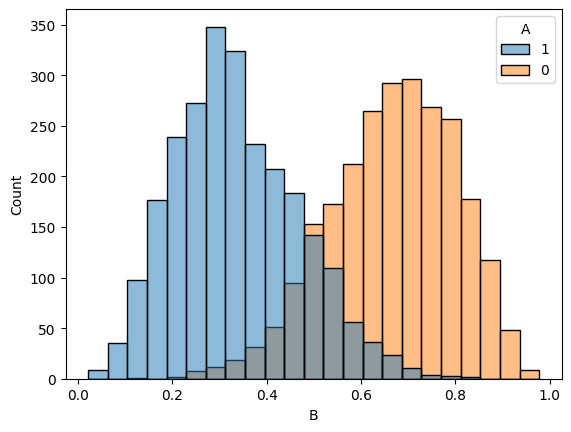

In [8]:
sns.histplot(data=df, x='B', hue='A', hue_order=[1, 0])

In [110]:
# Now let's try to estimate those parameters using SVI
pyro.clear_param_store()

# If you want to do MAP estimation instead (no uncertainty required), use AutoDelta instead. See https://pyro.ai/examples/mle_map.html.
guide = autoguide.AutoNormal(pyro.poutine.block(model, hide=["A", "B"])) 

svi = SVI(model=model,
          guide=guide,
          optim=ClippedAdam({"lr": 0.01, 'clip_norm': 1.0}),  # See here for how to use a more elaborate optimization scheme, e.g., with lr scheduling: https://pyro.ai/examples/svi_part_iv.html
          loss=TraceEnum_ELBO(max_plate_nesting=1))  # if we didn't have a discrete variable, we'd use Trace_ELBO

for i in range(5000):
    loss = svi.step(parameterized_samples['A'], parameterized_samples['B'])

RuntimeError: Boolean value of Tensor with more than one value is ambiguous
        Trace Shapes:      
         Param Sites:      
        Sample Sites:      
         a_prior dist | 2  
                value | 2  
b_concentrations dist | 2 2
                value | 2 2
Trace Shapes:
 Param Sites:
Sample Sites:
Trace Shapes:
 Param Sites:
Sample Sites:

In [69]:
pyro.clear_param_store()

# If you want to do MAP estimation instead (no uncertainty required), use AutoDelta instead. See https://pyro.ai/examples/mle_map.html.
guide = autoguide.AutoNormal(pyro.poutine.block(model, hide=["A", "B"])) 

svi = SVI(model=model,
          guide=guide,
          optim=ClippedAdam({"lr": 0.01, 'clip_norm': 1.0}),  # See here for how to use a more elaborate optimization scheme, e.g., with lr scheduling: https://pyro.ai/examples/svi_part_iv.html
          loss=TraceEnum_ELBO(max_plate_nesting=1))  # if we didn't have a discrete variable, we'd use Trace_ELBO

for i in range(5000):
    loss = svi.step(parameterized_samples['A'], parameterized_samples['B'])

RuntimeError: Boolean value of Tensor with more than one value is ambiguous
        Trace Shapes:        
         Param Sites:        
        Sample Sites:        
         a_prior dist     | 2
                value     | 2
b_concentrations dist 2 2 |  
                value 2 2 |  
Trace Shapes:
 Param Sites:
Sample Sites:
Trace Shapes:
 Param Sites:
Sample Sites:

In [70]:
# Now let's try to estimate those parameters using SVI
pyro.clear_param_store()

# If you want to do MAP estimation instead (no uncertainty required), use AutoDelta instead. See https://pyro.ai/examples/mle_map.html.
auto_guide = autoguide.AutoNormal(model) 

adam = Adam({"lr": 0.02})
elbo = TraceEnum_ELBO(max_plate_nesting=1)
svi = SVI(model, auto_guide, adam, elbo)

for i in range(5000):
    loss = svi.step(parameterized_samples['A'], parameterized_samples['B'])

RuntimeError: Boolean value of Tensor with more than one value is ambiguous
        Trace Shapes:        
         Param Sites:        
        Sample Sites:        
         a_prior dist     | 2
                value     | 2
b_concentrations dist 2 2 |  
                value 2 2 |  
Trace Shapes:
 Param Sites:
Sample Sites:
Trace Shapes:
 Param Sites:
Sample Sites: